<a href="https://colab.research.google.com/github/alessioborgi/DL_Project/blob/main/preprocesseingDSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q --upgrade pip # to avoid dependency conflicts
!pip install -q pyserini==0.12.0
!pip install -q pytorch-lightning transformers datasets torch wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 29.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [9]:
import torch
import numpy as np
from datetime import datetime
import pytorch_lightning as pl
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn.functional as F
from datasets import load_dataset
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.loggers import WandbLogger
from sklearn.cluster import AgglomerativeClustering
from transformers import AutoModel, AutoTokenizer, AutoTokenizer, AutoModelForSequenceClassification
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor, StochasticWeightAveraging, DeviceStatsMonitor
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [3]:
train_set = load_dataset("microsoft/ms_marco", "v1.1", split="train")
val_set = load_dataset("microsoft/ms_marco", "v1.1", split="validation")
test_set = load_dataset("microsoft/ms_marco", "v1.1", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10047 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/82326 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9650 [00:00<?, ? examples/s]

In [10]:
# load a pretrained transformer
# DSI prefer generative-based transformers, so T5 will be good enough (also mentioned by the paper)
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [76]:
print("Keys: ", train_set.features.keys())
print("Train: ", train_set.num_rows)
print("Validation: ", val_set.num_rows)
print("Test: ", test_set.num_rows)

Keys:  dict_keys(['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'])
Train:  82326
Validation:  10047
Test:  9650


In [22]:
i = 0
l = []
while i < train_set.num_rows:
    elem = train_set[i]
    l.append(len(elem["passages"]['passage_text']))
    i+=1

print(min(l), max(l))

1 12


In [69]:
class MSM_Dataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128, is_test=False):
        """
        Class used to represent the MS Marco Dataset

            > data: Dataset object from HuggingFace which is a dictionary composed by the following keys:

                - 'answers' (list of str)
                - 'passages' (dict) with these keys: {'is_selected' (list of int), 'passages_text' (list of str), 'url' (list of str)}
                - 'query' (str)
                - 'query_id' (int)
                - 'query_type' (str)
                - 'wellFormedAnswers' (list which is always empty apparently)

            > tokenizer: tokenizer used to generate embeddings (now we are using the T5 Tokenizer)
            > max_length: maximum length of a sequence
            > is_test: boolean which tells you if you have or not labels (test_set)

        """

        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_test = is_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # extract the element in position idx from the dataset
        elem = self.data[idx]

        answers_elem = elem["answers"]
        passages_elem = elem["passages"]
        query_elem = elem["query"]
        query_id_elem = elem["query_id"]
        query_type_elem = elem["query_type"]

        passage_text = passages_elem["passage_text"]

        # pass each passage_text to the tokenizer with the same query
        tokenized_inputs = []
        result = {"input_ids": []}
        for j in range(0, len(passage_text)):
            inputs = self.tokenizer(
                        query_elem,
                        passage_text[j],
                        truncation=False,
                        padding="max_length",
                        max_length=self.max_length,
                        return_tensors="pt"
                    )
            tokenized_inputs.append(inputs)

            result["input_ids"].append(inputs["input_ids"].squeeze(0))

        # label = None if self.is_test else 1 if item["passages"]["is_selected"][0] else 0

        # Add label only if it's not the test set
        # if not self.is_test:
        #     result["label"] = torch.tensor(label, dtype=torch.long)

        return result

In [70]:
train_data = MSM_Dataset(train_set, tokenizer)

In [72]:
class MSM_DataModule(pl.LightningDataModule):
    def __init__(self, train_data, validation_data, test_data, tokenizer, batch_size=32):
        """
        Data module for handling MS MARCO datasets.

            > train_data: training partition
            > validation_data: validation partition
            > test_data: test dasates partition
            > tokenizer: tokenizer used (currently T5)
            > batch_size: batch size used for our DataLoaders

        """
        super().__init__()
        self.train_data = MSM_Dataset(self.train_data, self.tokenizer)
        self.validation_data = MSM_Dataset(self.validation_data, self.tokenizer)
        self.test_data = MSM_Dataset(self.test_data, self.tokenizer, is_test=True)
        self.tokenizer = tokenizer
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

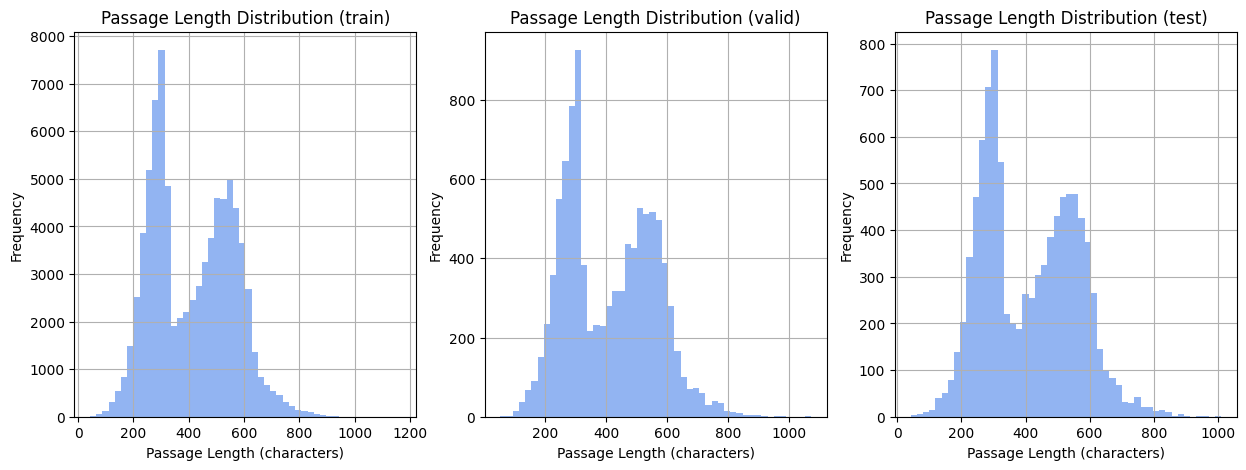

In [ ]:
# # Passage Length Distribution
# def plot_passage_length_distribution(dataset, split_name):
#     passage_lengths = [len(p["passage_text"][0]) for p in dataset["passages"]]
#     plt.hist(passage_lengths, bins=50, alpha=0.7, color="blue")
#     plt.title(f"Passage Length Distribution ({split_name})")
#     plt.xlabel("Passage Length (characters)")
#     plt.ylabel("Frequency")
#     plt.grid(True)
#     plt.show()

# Plot distribution for train, validation, and test splits
# plot_passage_length_distribution(ms_marco_train, "Train")
# plot_passage_length_distribution(ms_marco_validation, "Validation")
# plot_passage_length_distribution(ms_marco_test, "Test")


def plot_passages_length_distribution(dataset_dict):
    fig, axes = plt.subplots(nrows=1, ncols=len(dataset_dict.keys()), figsize=(15, 5))

    for i, split_name in enumerate(dataset_dict.keys()):
        ax = axes[i]
        dataset = dataset_dict[split_name]
        passage_lengths = [len(p["passage_text"][0]) for p in dataset["passages"]]
        ax.hist(passage_lengths, bins=50, alpha=0.7, color="cornflowerblue")
        ax.set_title(f"Passage Length Distribution ({split_name})")
        ax.set_xlabel("Passage Length (characters)")
        ax.set_ylabel("Frequency")
        ax.grid(True)

    plt.show()

plot_passages_length_distribution({"train": ms_marco_train, "valid": ms_marco_validation, "test": ms_marco_test})

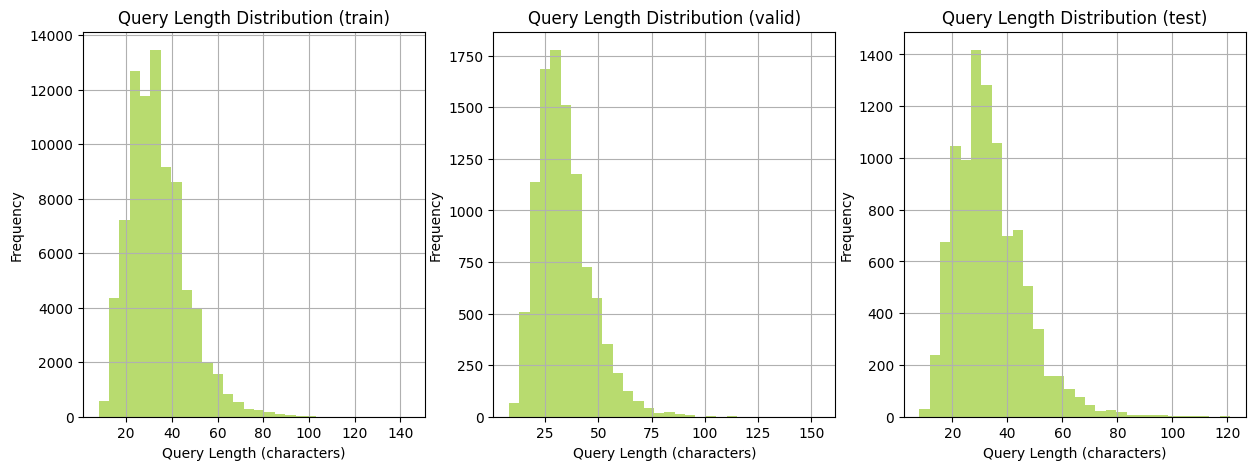

In [ ]:
# # Query Length Distribution
# def plot_query_length_distribution(dataset, split_name):
#     query_lengths = [len(q) for q in dataset["query"]]
#     plt.hist(query_lengths, bins=30, alpha=0.7, color="green")
#     plt.title(f"Query Length Distribution ({split_name})")
#     plt.xlabel("Query Length (characters)")
#     plt.ylabel("Frequency")
#     plt.grid(True)
#     plt.show()

# # Plot distribution for train, validation, and test splits
# plot_query_length_distribution(ms_marco_train, "Train")
# plot_query_length_distribution(ms_marco_validation, "Validation")
# plot_query_length_distribution(ms_marco_test, "Test")

def plot_passages_length_distribution(dataset_dict):
    fig, axes = plt.subplots(nrows=1, ncols=len(dataset_dict.keys()), figsize=(15, 5))

    for i, split_name in enumerate(dataset_dict.keys()):
        ax = axes[i]
        dataset = dataset_dict[split_name]
        query_lengths = [len(q) for q in dataset["query"]]
        ax.hist(query_lengths, bins=30, alpha=0.7, color="yellowgreen")
        ax.set_title(f"Query Length Distribution ({split_name})")
        ax.set_xlabel("Query Length (characters)")
        ax.set_ylabel("Frequency")
        ax.grid(True)

    plt.show()

plot_passages_length_distribution({"train": ms_marco_train, "valid": ms_marco_validation, "test": ms_marco_test})

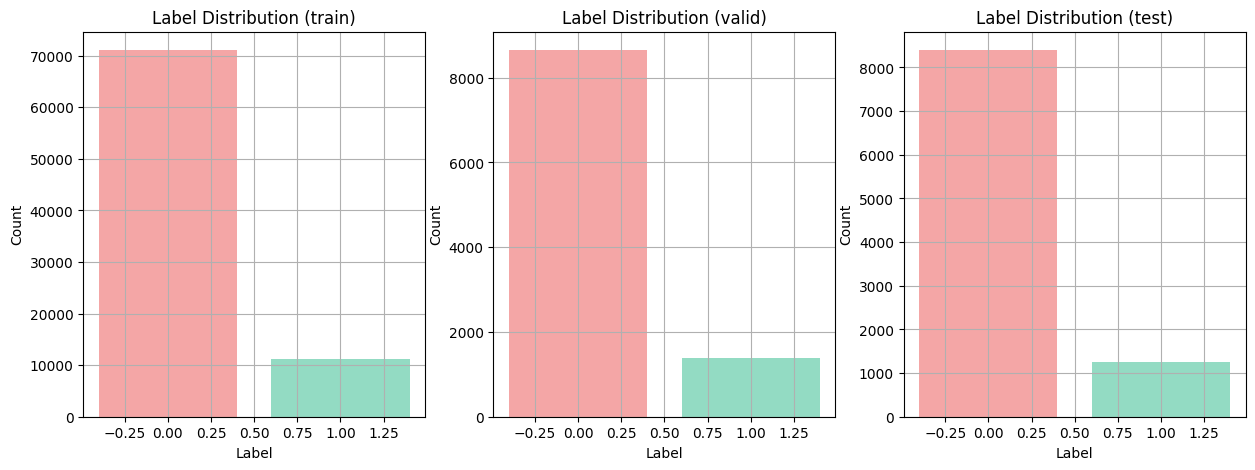

In [ ]:
# # Label Distribution
# def plot_label_distribution(dataset, split_name):
#     labels = [1 if p["is_selected"][0] else 0 for p in dataset["passages"]]
#     label_counts = {0: labels.count(0), 1: labels.count(1)}

#     plt.bar(label_counts.keys(), label_counts.values(), alpha=0.7, color=["red", "green"])
#     plt.xticks([0, 1], ["Not Selected", "Selected"])
#     plt.title(f"Label Distribution ({split_name})")
#     plt.xlabel("Label")
#     plt.ylabel("Count")
#     plt.show()

#     print(f"Label Counts ({split_name}): {label_counts}")

# # Plot label distribution for train and validation splits
# plot_label_distribution(ms_marco_train, "Train")
# plot_label_distribution(ms_marco_validation, "Validation")



def plot_label_distribution(dataset_dict):
    fig, axes = plt.subplots(nrows=1, ncols=len(dataset_dict.keys()), figsize=(15, 5))

    for i, split_name in enumerate(dataset_dict.keys()):
        ax = axes[i]
        dataset = dataset_dict[split_name]
        labels = [1 if p["is_selected"][0] else 0 for p in dataset["passages"]]
        label_counts = {0: labels.count(0), 1: labels.count(1)}
        ax.bar(label_counts.keys(), label_counts.values(), alpha=0.7, color=["lightcoral", "mediumaquamarine"])
        ax.set_title(f"Label Distribution ({split_name})")
        ax.set_xlabel("Label")
        ax.set_ylabel("Count")
        ax.grid(True)

    plt.show()

plot_label_distribution({"train": ms_marco_train, "valid": ms_marco_validation, "test": ms_marco_test})

In [ ]:
# Unique Queries and Passages
def print_unique_counts(dataset, split_name):
    unique_queries = len(set(dataset["query"]))
    unique_passages = len(set([p["passage_text"][0] for p in dataset["passages"]]))
    print(f"Unique Queries in {split_name}: {unique_queries}")
    print(f"Unique Passages in {split_name}: {unique_passages}")

# Print unique counts for train, validation, and test splits
print_unique_counts(ms_marco_train, "Train")
print_unique_counts(ms_marco_validation, "Validation")
print_unique_counts(ms_marco_test, "Test")

Unique Queries in Train: 82326
Unique Passages in Train: 81230
Unique Queries in Validation: 10047
Unique Passages in Validation: 10019
Unique Queries in Test: 9650
Unique Passages in Test: 9629


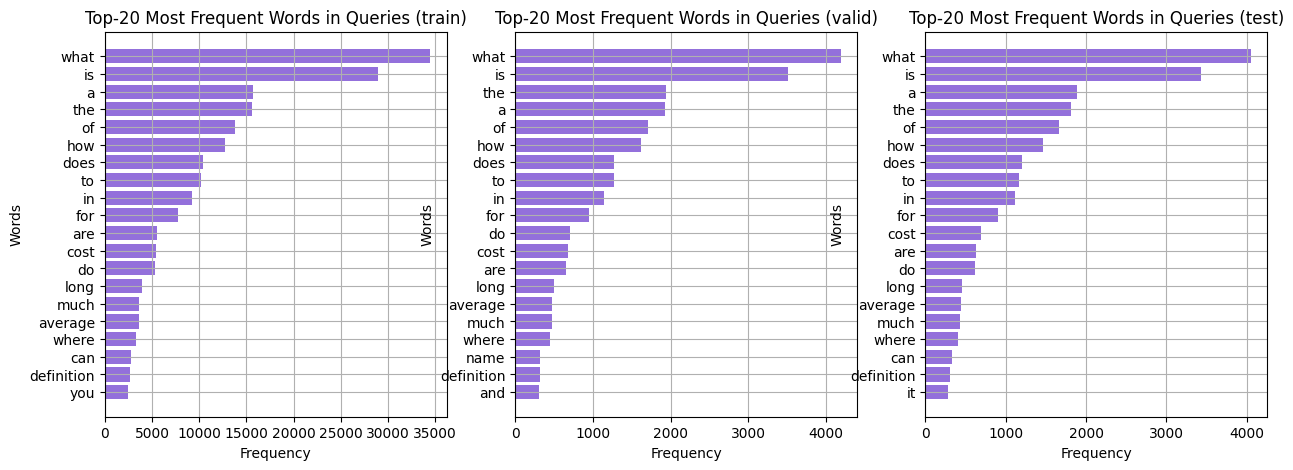

In [ ]:
# # Top-N Most Frequent Words in Queries
# def plot_top_words_in_queries(dataset, split_name, top_n=20):
#     all_queries = " ".join(dataset["query"])
#     word_counts = Counter(all_queries.split())
#     most_common_words = word_counts.most_common(top_n)

#     words, counts = zip(*most_common_words)
#     plt.barh(words, counts, color="purple")
#     plt.gca().invert_yaxis()
#     plt.title(f"Top-{top_n} Most Frequent Words in Queries ({split_name})")
#     plt.xlabel("Frequency")
#     plt.ylabel("Words")
#     plt.show()

# # Plot top-20 words for train, validation, and test splits
# plot_top_words_in_queries(ms_marco_train, "Train")
# plot_top_words_in_queries(ms_marco_validation, "Validation")
# plot_top_words_in_queries(ms_marco_test, "Test")



def plot_top_words_in_queries(dataset_dict, top_n=20):
    fig, axes = plt.subplots(nrows=1, ncols=len(dataset_dict.keys()), figsize=(15, 5))

    for i, split_name in enumerate(dataset_dict.keys()):
        ax = axes[i]
        dataset = dataset_dict[split_name]
        all_queries = " ".join(dataset["query"])
        word_counts = Counter(all_queries.split())
        most_common_words = word_counts.most_common(top_n)

        words, counts = zip(*most_common_words)
        ax.barh(words, counts, color="mediumpurple")
        ax.invert_yaxis()
        ax.set_title(f"Top-{top_n} Most Frequent Words in Queries ({split_name})")
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Words")
        ax.grid(True)

    plt.show()

plot_top_words_in_queries({"train": ms_marco_train, "valid": ms_marco_validation, "test": ms_marco_test})

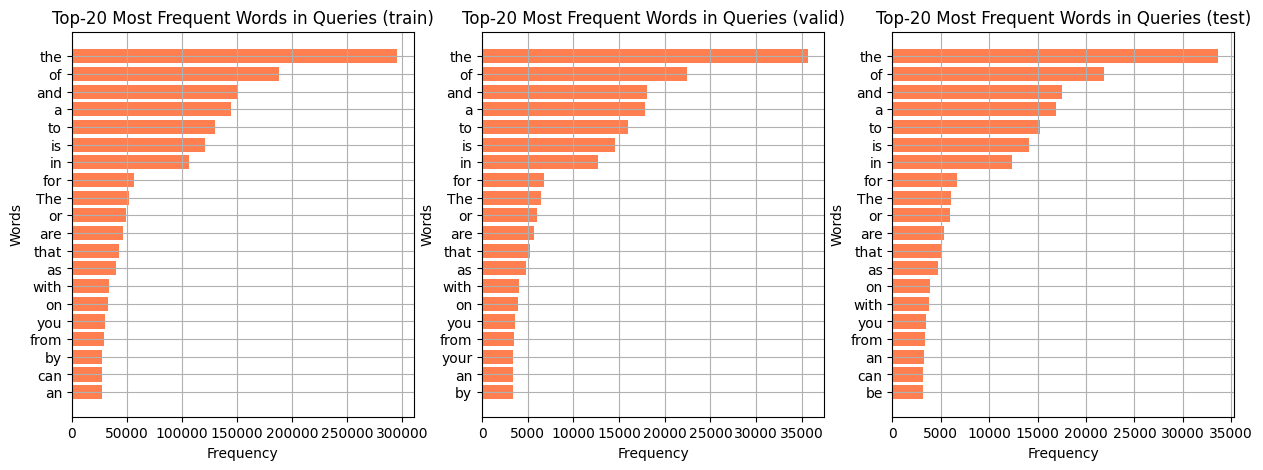

In [ ]:
# # Top-N Most Frequent Words in Passages
# def plot_top_words_in_passages(dataset, split_name, top_n=20):
#     all_passages = " ".join([p["passage_text"][0] for p in dataset["passages"]])
#     word_counts = Counter(all_passages.split())
#     most_common_words = word_counts.most_common(top_n)

#     words, counts = zip(*most_common_words)
#     plt.barh(words, counts, color="orange")
#     plt.gca().invert_yaxis()
#     plt.title(f"Top-{top_n} Most Frequent Words in Passages ({split_name})")
#     plt.xlabel("Frequency")
#     plt.ylabel("Words")
#     plt.show()

# # Plot top-20 words for train, validation, and test splits
# plot_top_words_in_passages(ms_marco_train, "Train")
# plot_top_words_in_passages(ms_marco_validation, "Validation")
# plot_top_words_in_passages(ms_marco_test, "Test")



def plot_top_words_in_passages(dataset_dict, top_n=20):
    fig, axes = plt.subplots(nrows=1, ncols=len(dataset_dict.keys()), figsize=(15, 5))

    for i, split_name in enumerate(dataset_dict.keys()):
        ax = axes[i]
        dataset = dataset_dict[split_name]
        all_passages = " ".join([p["passage_text"][0] for p in dataset["passages"]])
        word_counts = Counter(all_passages.split())
        most_common_words = word_counts.most_common(top_n)

        words, counts = zip(*most_common_words)
        ax.barh(words, counts, color="coral")
        ax.invert_yaxis()
        ax.set_title(f"Top-{top_n} Most Frequent Words in Queries ({split_name})")
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Words")
        ax.grid(True)

    plt.show()

plot_top_words_in_passages({"train": ms_marco_train, "valid": ms_marco_validation, "test": ms_marco_test})

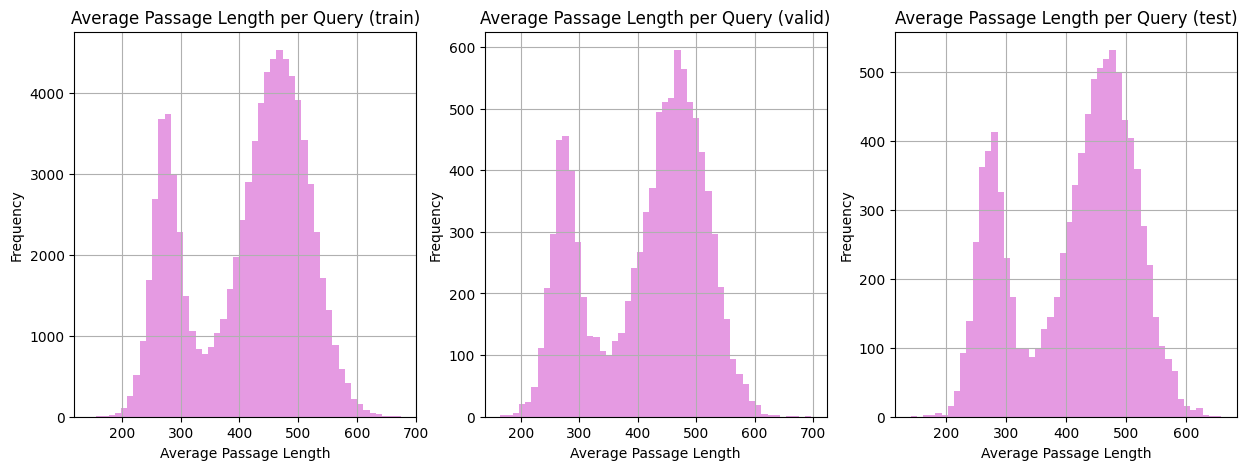

In [ ]:
# # Average Passage Length per Query
# def average_passage_length_per_query(dataset, split_name):
#     avg_lengths = [np.mean([len(passage) for passage in p["passage_text"]]) for p in dataset["passages"]]
#     plt.hist(avg_lengths, bins=50, alpha=0.7, color="magenta")
#     plt.title(f"Average Passage Length per Query ({split_name})")
#     plt.xlabel("Average Passage Length")
#     plt.ylabel("Frequency")
#     plt.grid(True)
#     plt.show()

# # Analyze for train, validation, and test splits
# average_passage_length_per_query(ms_marco_train, "Train")
# average_passage_length_per_query(ms_marco_validation, "Validation")
# average_passage_length_per_query(ms_marco_test, "Test")


def analyze_passages_per_query(dataset_dict):
    fig, axes = plt.subplots(nrows=1, ncols=len(dataset_dict.keys()), figsize=(15, 5))

    for i, split_name in enumerate(dataset_dict.keys()):
        ax = axes[i]
        dataset = dataset_dict[split_name]

        avg_lengths = [np.mean([len(passage) for passage in p["passage_text"]]) for p in dataset["passages"]]
        ax.hist(avg_lengths, bins=50, alpha=0.7, color="orchid")
        ax.set_title(f"Average Passage Length per Query ({split_name})")
        ax.set_xlabel("Average Passage Length")
        ax.set_ylabel("Frequency")
        ax.grid(True)

    plt.show()

analyze_passages_per_query({"train": ms_marco_train, "valid": ms_marco_validation, "test": ms_marco_test})

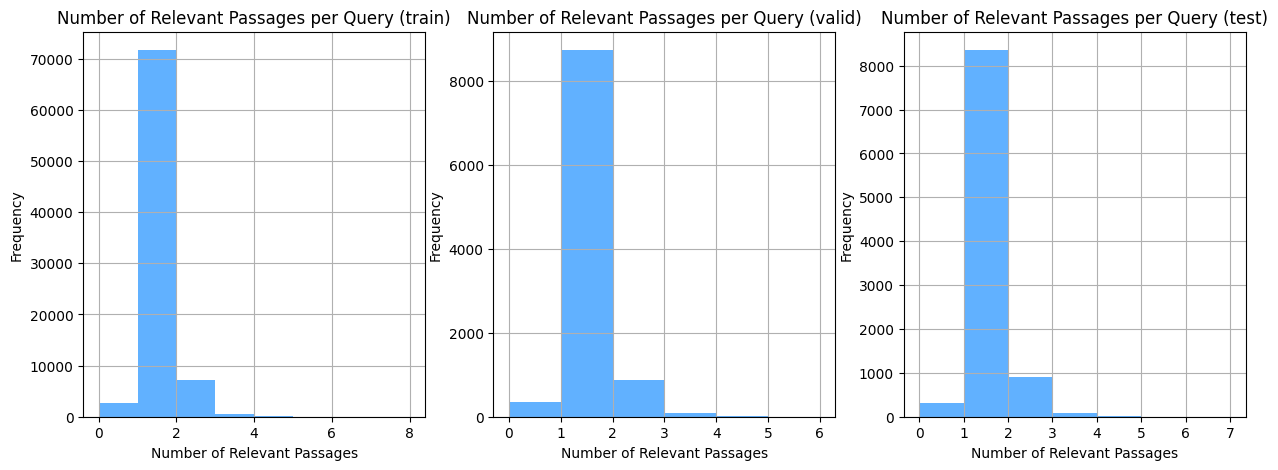

In [ ]:
# # Relevance Analysis: Number of Relevant Passages per Query
# def analyze_relevance_distribution(dataset, split_name):
#     relevant_counts = [sum(p["is_selected"]) for p in dataset["passages"]]
#     plt.hist(relevant_counts, bins=range(0, max(relevant_counts) + 2), alpha=0.7, color="lime")
#     plt.title(f"Number of Relevant Passages per Query ({split_name})")
#     plt.xlabel("Number of Relevant Passages")
#     plt.ylabel("Frequency")
#     plt.grid(True)
#     plt.show()

# # Analyze for train and validation splits (not test, as it may lack labels)
# analyze_relevance_distribution(ms_marco_train, "Train")
# analyze_relevance_distribution(ms_marco_validation, "Validation")





def analyze_relevance_distribution(dataset_dict):
    fig, axes = plt.subplots(nrows=1, ncols=len(dataset_dict.keys()), figsize=(15, 5))

    for i, split_name in enumerate(dataset_dict.keys()):
        ax = axes[i]
        dataset = dataset_dict[split_name]

        relevant_counts = [sum(p["is_selected"]) for p in dataset["passages"]]
        ax.hist(relevant_counts, bins=range(0, max(relevant_counts) + 2), alpha=0.7, color="dodgerblue")
        ax.set_title(f"Number of Relevant Passages per Query ({split_name})")
        ax.set_xlabel("Number of Relevant Passages")
        ax.set_ylabel("Frequency")
        ax.grid(True)

    plt.show()

analyze_relevance_distribution({"train": ms_marco_train, "valid": ms_marco_validation, "test": ms_marco_test})

In [ ]:
# Lexical Diversity: Calculate the ratio of unique words to total words as a measure of diversity.
def calculate_lexical_diversity(dataset, split_name):
    query_text = " ".join(dataset["query"])
    passage_text = " ".join([p["passage_text"][0] for p in dataset["passages"]])

    query_words = query_text.split()
    passage_words = passage_text.split()

    query_diversity = len(set(query_words)) / len(query_words)
    passage_diversity = len(set(passage_words)) / len(passage_words)

    print(f"{split_name} - Lexical Diversity (Queries): {query_diversity:.4f}")
    print(f"{split_name} - Lexical Diversity (Passages): {passage_diversity:.4f}")

# Calculate for train, validation, and test splits
calculate_lexical_diversity(ms_marco_train, "Train")
calculate_lexical_diversity(ms_marco_validation, "Validation")
calculate_lexical_diversity(ms_marco_test, "Test")

Train - Lexical Diversity (Queries): 0.0784
Train - Lexical Diversity (Passages): 0.0566
Validation - Lexical Diversity (Queries): 0.1818
Validation - Lexical Diversity (Passages): 0.1203
Test - Lexical Diversity (Queries): 0.1855
Test - Lexical Diversity (Passages): 0.1223


In [ ]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Create data module
data_module = MSMarcoDataModule(
    train_data=ms_marco_train,
    validation_data=ms_marco_validation,
    test_data=ms_marco_test,
    tokenizer=tokenizer,
    batch_size=32
)

# Prepare datasets
data_module.setup()

# Access dataloaders
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Iterate through the training loader
for batch in train_loader:
    input_ids = batch["input_ids"]  # Tokenized input IDs
    attention_mask = batch["attention_mask"]  # Attention mask
    # labels = batch["labels"]  # Labels for the batch
    print("Batch input_ids shape:", input_ids.shape)
    print("Batch attention_mask shape:", attention_mask.shape)
    # print("Batch labels shape:", labels.shape)
    break  # Stop after printing one batch

Batch input_ids shape: torch.Size([32, 128])
Batch attention_mask shape: torch.Size([32, 128])


In [ ]:
# use examples of document ids (docids) and documents
doc_ids = ["doc_001", "doc_002", "doc_003"]

# note, here documents are made by a single segment
# in genral we can have multiple segments belonging to the same document
documents = [
    "Deep learning is a subset of machine learning that uses neural networks.",
    "Reinforcement learning is a type of machine learning for decision-making.",
    "Transfer learning reuses pre-trained models to solve new tasks."
]

queries = [
    "What is deep learning?",
    "Explain reinforcement learning.",
    "How does transfer learning work?"
]

In [ ]:
# tokenize docids (vanilla tokenization, just for understanding)
def tokenize_doc_id(doc_id):
    return " ".join(list(doc_id.replace("_", " _ ")))

tokenized_doc_ids = [tokenize_doc_id(doc_id) for doc_id in doc_ids]
print("Tokenized Document IDs:", tokenized_doc_ids)

Tokenized Document IDs: ['d o c   _   0 0 1', 'd o c   _   0 0 2', 'd o c   _   0 0 3']


In [ ]:
# query-document pairs (note that we need pseudo-query)
training_data = [
    (query, doc_id) for query, doc_id in zip(queries, tokenized_doc_ids)
]

In [ ]:
training_data

[('What is deep learning?', 'd o c   _   0 0 1'),
 ('Explain reinforcement learning.', 'd o c   _   0 0 2'),
 ('How does transfer learning work?', 'd o c   _   0 0 3')]

In [ ]:
def prepare_inputs(query, tokenized_doc_id, tokenizer, max_length=512):
    # input: query
    input_encodings = tokenizer(
        query,
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )

    # output: tokenized_docid
    target_encodings = tokenizer(
        tokenized_doc_id,
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt" # pt stands for 'pytorch tensor'
    )

    return input_encodings, target_encodings

query, tokenized_doc_id = training_data[0]
input_encodings, target_encodings = prepare_inputs(query, tokenized_doc_id, tokenizer)

# print("Input Encodings:", input_encodings)
# print("Target Encodings:", target_encodings)

In [ ]:
# common practice: set decoder's start token ID to T5's default value
# (PAD token for now)
model.config.decoder_start_token_id = tokenizer.pad_token_id

In [ ]:
from pyserini.encode import TctColBertQueryEncoder
from pyserini.search.faiss import FaissSearcher

encoder = TctColBertQueryEncoder('castorini/tct_colbert-v2-hnp-msmarco')
faiss_searcher = FaissSearcher.from_prebuilt_index(
    'msmarco-v1-passage.tct_colbert-v2-hnp',
    encoder)
hits = faiss_searcher.search('what is a lobster roll')

for i in range(0, 10):
    print(f'{i+1:2} {hits[i].docid:7} {hits[i].score:.5f}')

In [ ]:
from pyserini.search import SimpleSearcher
from pyserini.dsearch import SimpleDenseSearcher
from transformers import AutoTokenizer, AutoModel
import numpy as np

# Step 1: BM25 Retrieval
def bm25_retrieve(query, searcher, k=1000):
    hits = searcher.search(query, k=k)
    bm25_results = [(hit.docid, hit.score, hit.raw) for hit in hits]
    return bm25_results

# Step 2: TCT-ColBERT Scoring
def tct_colbert_score(query, bm25_results, dense_searcher):
    query_vector = dense_searcher.query_encoder.encode(query)
    document_vectors = []
    docids = []
    for docid, _, doc_text in bm25_results:
        docids.append(docid)
        document_vectors.append(dense_searcher.doc_encoder.encode(doc_text))

    # Compute dense similarity scores
    document_vectors = np.vstack(document_vectors)
    scores = np.dot(document_vectors, query_vector.T).flatten()
    return list(zip(docids, scores))

# Step 3: Combine Scores
def combine_scores(bm25_results, dense_scores, alpha=0.5):
    # Normalize BM25 and Dense scores
    bm25_scores = {docid: score for docid, score, _ in bm25_results}
    dense_scores = {docid: score for docid, score in dense_scores}

    # Combine scores using a weighted sum
    combined_scores = {}
    for docid in set(bm25_scores.keys()).union(dense_scores.keys()):
        bm25_score = bm25_scores.get(docid, 0)
        dense_score = dense_scores.get(docid, 0)
        combined_scores[docid] = alpha * bm25_score + (1 - alpha) * dense_score

    # Sort by combined score
    return sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

# Step 4: Execute Hybrid Retrieval
if __name__ == "__main__":
    # Initialize BM25 searcher
    bm25_searcher = SimpleSearcher('index-msmarco-passage')
    bm25_searcher.set_bm25(k1=0.9, b=0.4)

    # Initialize TCT-ColBERT dense searcher
    dense_searcher = SimpleDenseSearcher.from_prebuilt_index('msmarco-passage-tct_colbert-hnsw')

    # Query
    query = "What is the capital of France?"

    # Retrieve top-k candidates using BM25
    bm25_results = bm25_retrieve(query, bm25_searcher, k=1000)

    # Re-score candidates using TCT-ColBERT
    dense_scores = tct_colbert_score(query, bm25_results, dense_searcher)

    # Combine BM25 and TCT-ColBERT scores
    combined_results = combine_scores(bm25_results, dense_scores, alpha=0.7)

    # Print top results
    print("Top Combined Results:")
    for rank, (docid, score) in enumerate(combined_results[:10], start=1):
        print(f"Rank {rank}: DocID: {docid}, Combined Score: {score:.4f}")